In [1]:
clear

## Caricamento Dati

La seguente funzione permette di caricare matrici sparse, provenienti dal sito [https://sparse.tamu.edu/](https://sparse.tamu.edu/), salvate su file nel formato matlab.<br>
Questa funzione riesce a gestire sia i vecchi formati (`< matlab v7.3`) che quelli nuovi.

In [2]:
function A = loadFunctionFromData(dataPath)
    disp(["🦍 Loading file: "  dataPath])
    load(dataPath)
    
%   se nel file è presente una `struct` allora vuol dire 
%   che sto utilizzando il nuovo formato e va convertito
%   per essere utilizzato da Octave
    if isstruct(Problem.A)
        n = length(Problem.A.jc)-1;
        ii = repelems(1:n, [1:n; diff(Problem.A.jc)]);
        A = sparse(Problem.A.ir+1, ii, Problem.A.data);
    else
        A = Problem.A;
    end
endfunction

In [3]:
% Esempio di come utilizzare la precedente funzione
% whos
% A = loadFunctionFromData('./data/cage15.mat');
% columns(A)
% rows(A)
% clear
% A = loadFunctionFromData('./data/vas_stokes_2M.mat');
% columns(A)
% rows(A)

La seguente funzione genera i dati iniziali per poter utilizzare GMRES.

In [4]:
function [A b x0] = generateData(dim, den, seed=69, randx0=false)
    rand("seed", seed);
    A = sprand(dim, dim, den);
    b = rand(dim, 1);
    
    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

In [5]:
function [A b x0] = generateData2(dim, n=-4, seed=69, randx0=false)
    rand("seed", seed);
    mu = 0;
    sigma = 1/(2*sqrt(dim));
    A = n * eye(dim) + normrnd(mu, sigma, dim);
    b = ones(dim, 1);
%     A = sprand(dim, dim, den);
%     b = rand(dim, 1);
    
    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

GMRES function

In [6]:
function [x res] = mygmres(A, b, x0, k, tol)
    n = size(b)(1);
    r0 = b - A * x0;
    beta = norm(r0, 2);
    
    H = zeros(k+2, k+1);
    Q = zeros(n, k+1);
    Q(:, 1) = r0/norm(r0, 2);
    
    en = zeros(k+2, 1);
    en(1) = 1;
        
    for j = 1:k  %% TODO: ricontrollare
%         imagesc(H);
        v = A*Q(:, j);   
        for i = 1:j
            H(i,j) = Q(:,i)' * v;
            v = v - H(i, j) * Q(:, i);
        end
        
        % ortogonalizzazione ??
        v = mgorth(v, Q);
%         H = gramschmidt(H);
%         Q = gramschmidt(Q);
        
        H(j+1, j) = norm(v, 2);
        Q(:, j+1) = v / H(j+1, j);
        
%         if (abs(H(j+1, j)) > tol)
%             Q(:, j+1) = Q(:,j+1)/H(j+1,j);
%         end
        
        e1 = en(1:j+2);
        
        y =(H(1:j+2,1:j+1))\(beta *e1);
%         y =(H(1:j+2,1:j+1))\(beta *e1);
        res(j) = norm(H(1:j+2,1:j+1)*y - beta*e1, 2);

        if (res(j) < tol)
            x = Q(:, 1:j+1)*y +x0;
            disp('🚀 Raggiunta Tolleranza, stop');
            imagesc(H);
            return;
        end
    end
    x = Q(:, 1:j+1)*y +x0;
    disp('🐌 Raggiunto massimo numero di Iterazioni');
    imagesc(H);

endfunction

## Test 1 - Random Matrix

In [7]:
[A, b, x0] = generateData(100, .5);

In [8]:
% A
% b
% x0
% L = gramschmidt(A)

🐌 Raggiunto massimo numero di Iterazioni


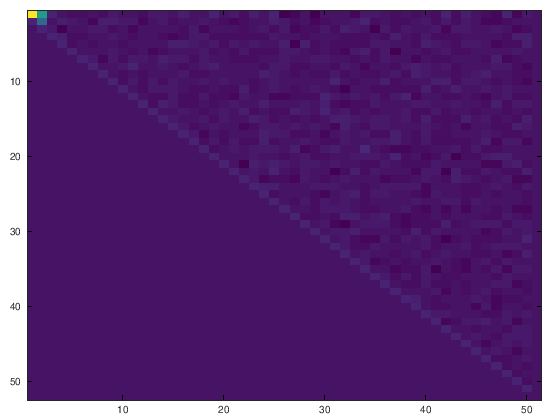

In [9]:
[x, res] = mygmres(A, b, x0, 50, 1e-10);

In [10]:
x
x_true = A\b
max(x_true-x)

x =

   4.4201e-02
  -4.1279e-03
   4.2968e-02
  -3.5338e-03
   4.8635e-02
   2.4289e-02
   1.2011e-03
   3.1120e-02
  -7.0268e-03
   1.4508e-02
  -1.7097e-04
   2.4878e-02
   6.2583e-02
  -2.5932e-03
   2.7875e-02
   2.0072e-02
   4.3168e-02
  -5.3860e-03
   4.4543e-02
   3.0766e-02
   5.7130e-03
   5.0829e-02
  -1.2621e-02
   1.6960e-02
   3.7923e-02
  -1.2432e-02
  -3.1310e-03
   3.8166e-02
   2.4917e-03
   4.7322e-02
   2.9952e-02
   2.7014e-02
   6.1976e-02
  -1.0369e-03
   1.5877e-02
   7.2078e-03
   2.7721e-02
   1.7046e-02
   4.7121e-02
   2.7525e-02
  -2.3732e-03
   5.6331e-02
  -4.3042e-03
   3.4995e-02
   4.6499e-02
   4.5734e-02
   2.1907e-02
   5.3691e-02
   2.8005e-02
   2.8274e-02
   1.8649e-02
   5.6404e-02
   4.5339e-02
   3.9993e-02
   4.3605e-02
   6.6429e-02
   1.1399e-02
   5.2815e-02
   2.8207e-02
   2.9847e-02
   5.3352e-02
   5.3772e-02
   4.7085e-02
  -1.5444e-02
   5.1572e-02
   5.6228e-02
   2.1000e-02
   4.4152e-02
   4.5363e-02
   1.5875e-03
   2.6607e-02
 

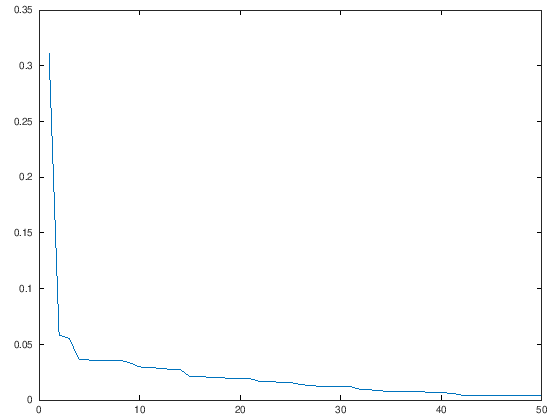

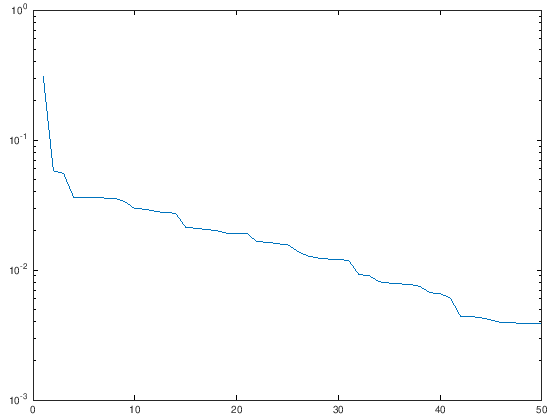

In [11]:
figure();
plot(res);
figure();
semilogy(res);

## Test 2 - randnorm()

🍌 n = -4
🚀 Raggiunta Tolleranza, stop
approx_error =  0.12744
🍌 n = -2
🚀 Raggiunta Tolleranza, stop
approx_error =  0.43624
🍌 n = 0
🐌 Raggiunto massimo numero di Iterazioni
approx_error =  76.429
🍌 n = 2
🚀 Raggiunta Tolleranza, stop
approx_error =  0.46084
🍌 n = 4
🚀 Raggiunta Tolleranza, stop
approx_error =  0.10026


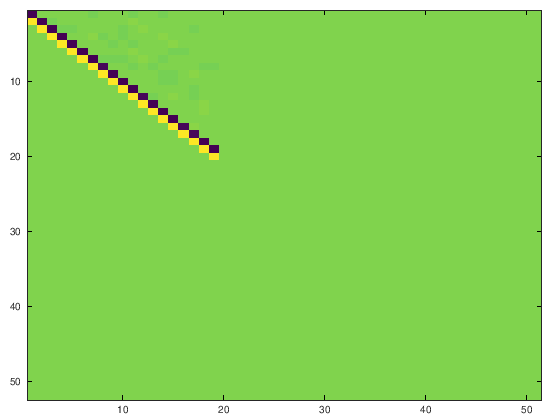

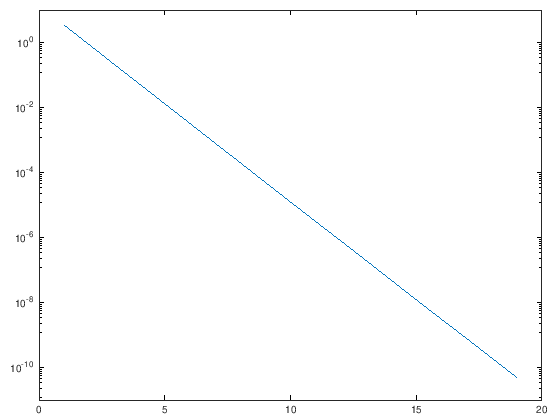

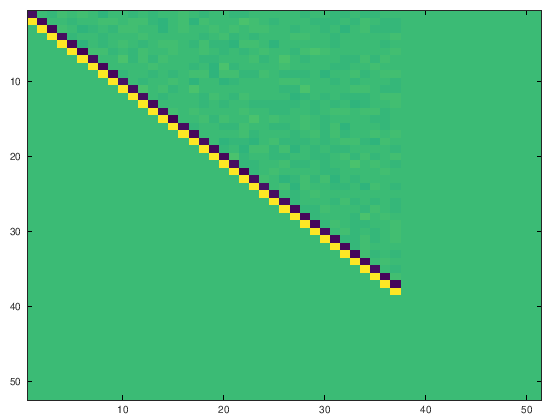

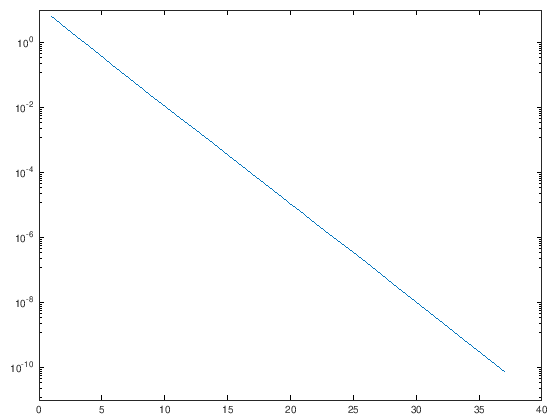

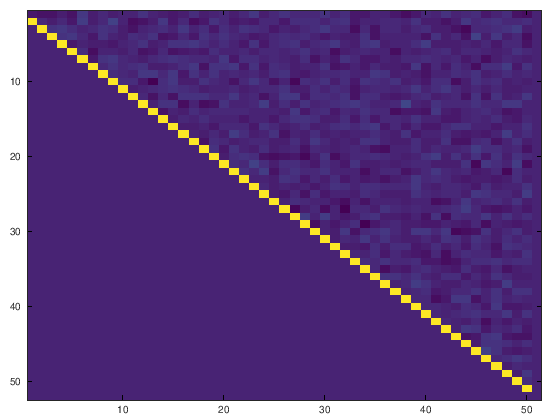

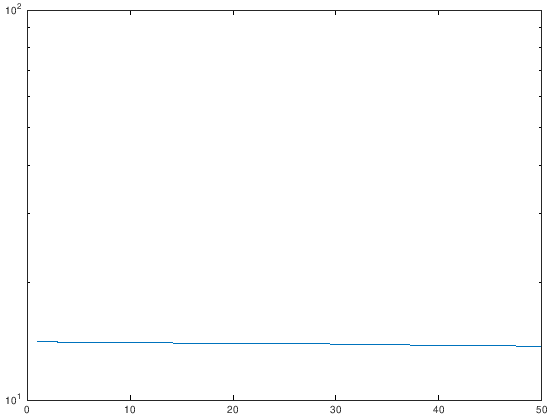

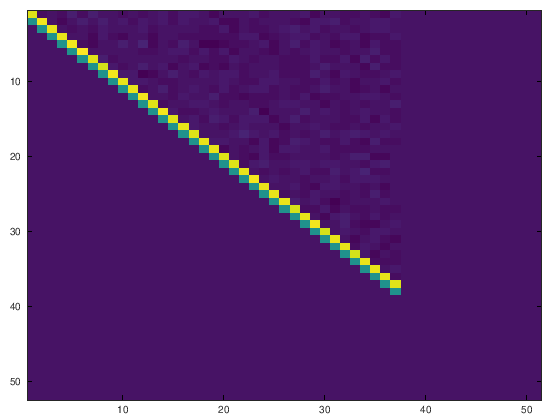

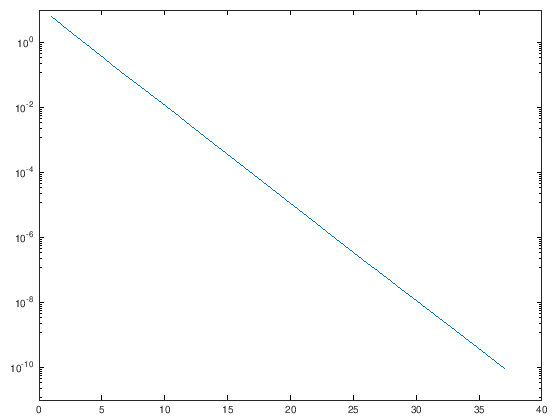

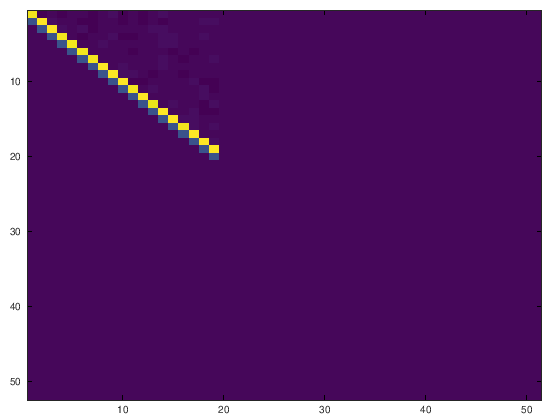

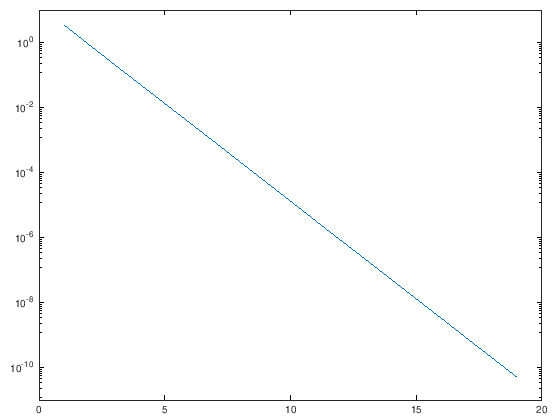

In [12]:
for n = [-4 -2 0 2 4]
    figure();
    printf("🍌 n = %d\n", n)
    [A, b, x0] = generateData2(200, n=n);
    [x, res] = mygmres(A, b, x0, 50, 1e-10);
    
    % x;
    x_true = A\b;
    approx_error = max(x_true-x)
    
    figure();
    title(["GMRES with n = " mat2str(n)]);
    semilogy(res);
end

## GMRES(m)

In [13]:
function [x res] = myrgmres(A, b, x0, k, tol, m)
    restartCount = 0;
    res = [];
    n = size(b)(1);
    en = zeros(k+2, 1);
    en(1) = 1;
    
    while (restartCount < m)
        H = zeros(k+2, k+1);
        Q = zeros(n, k+1);

        r0 = b - A * x0;
        beta = norm(r0, 2);
        Q(:, 1) = r0/norm(r0, 2);

        for j = 1:k  %% TODO: ricontrollare
    %         imagesc(H);
            v = A*Q(:, j);   
            for i = 1:j
                H(i,j) = Q(:,i)' * v;
                v = v - H(i, j) * Q(:, i);
            end
%             v = myGramschmidt(v);
%             v =  gramschmidt(v);
            v = mgorth(v, Q);  % equivalente a quella sopra
            H(j+1, j) = norm(v, 2);
%             Q(:, j+1) = mgorth(Q(:, j+1), Q); 
            Q(:, j+1) = v / H(j+1, j);
            
    %         if (abs(H(j+1, j)) > tol)
    %             Q(:, j+1) = Q(:,j+1)/H(j+1,j);
    %         end

            e1 = en(1:j+2);

            y =(H(1:j+2,1:j+1))\(beta *e1);
            res = [res norm(H(1:j+2,1:j+1)*y - beta*e1, 2)];

            if (res(end) < tol)
                x = Q(:, 1:j+1)*y +x0;
                disp('🚀 Raggiunta Tolleranza, stop');
                imagesc(H);
                return;
            end
        end
        x = Q(:, 1:j+1)*y +x0;
        x0 = x;
%         sum(x0)
        restartCount = restartCount + 1;
        disp('🐌 Raggiunto massimo numero di Iterazioni');
        disp('🗿 Restarting ...');
%         imagesc(H);
    end
    x = Q(:, 1:j+1)*y +x0;
    disp('❌ Raggiunto massimo numero di Restart');
    imagesc(H);
endfunction

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto ma

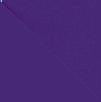

In [14]:
[A, b, x0] = generateData(200, .5);
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 50);

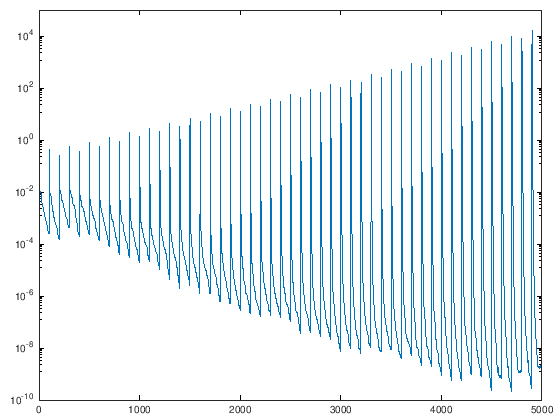

In [15]:
semilogy(res);

🍌 n = -4
🚀 Raggiunta Tolleranza, stop
approx_error =  0.086834
normm =  1.9258
🍌 n = -2
🚀 Raggiunta Tolleranza, stop
approx_error =  0.51622
normm =  4.3259
🍌 n = 0
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
❌ Raggiunto massimo numero di Restart
approx_error =  208.52
normm =  12.710
🍌 n = 2
🚀 Raggiunta Tolleranza, stop
approx_error =  0.38168
normm =  4.1076
🍌 n = 4
🚀 Raggiunta Tolleranza, stop
approx_error =  0.083456
normm =  1.8354


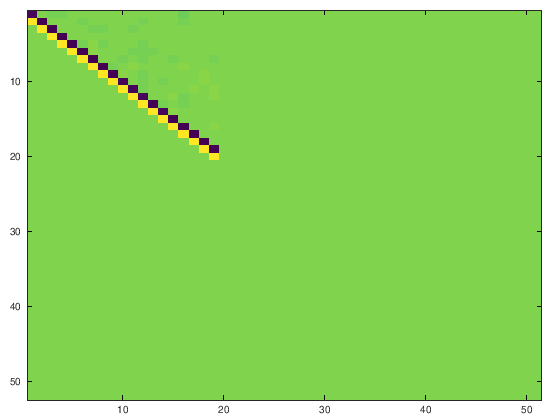

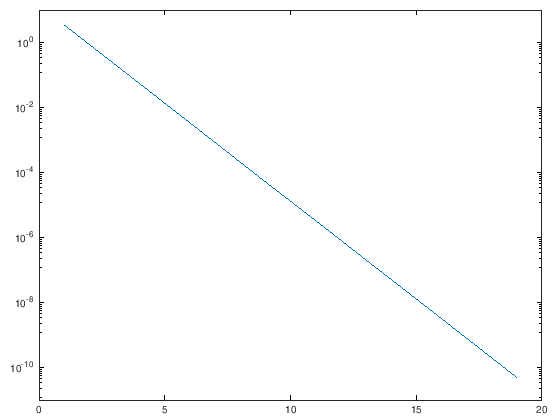

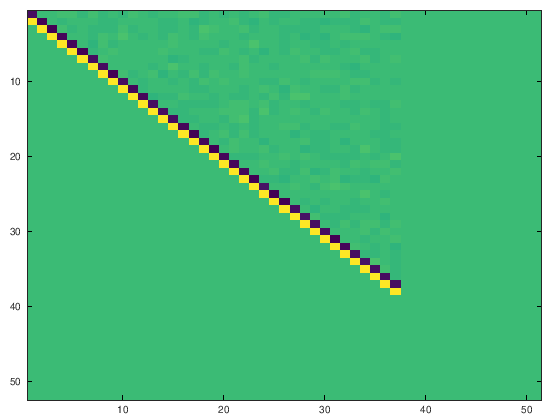

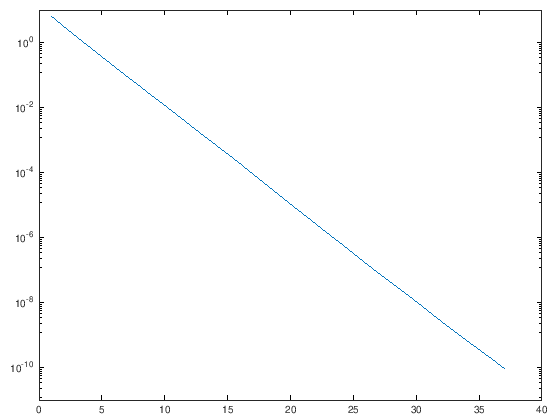

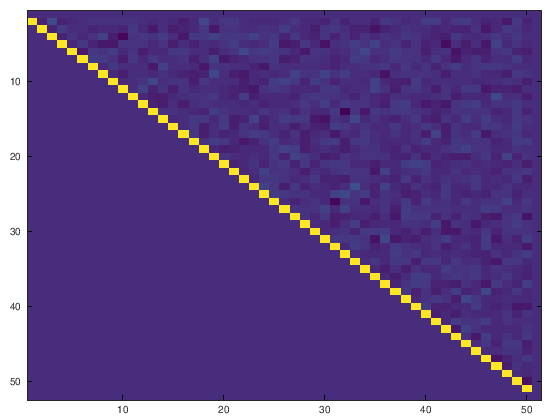

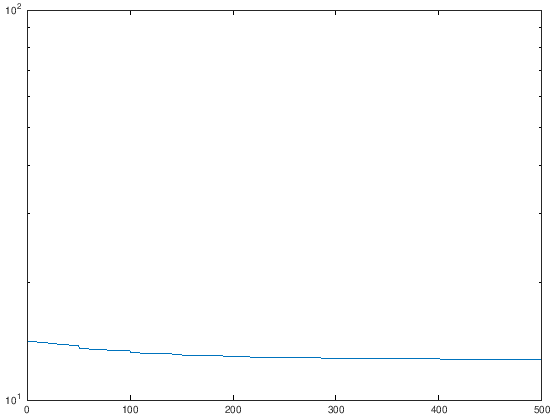

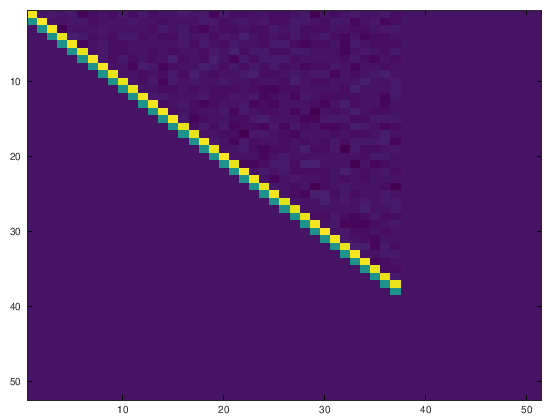

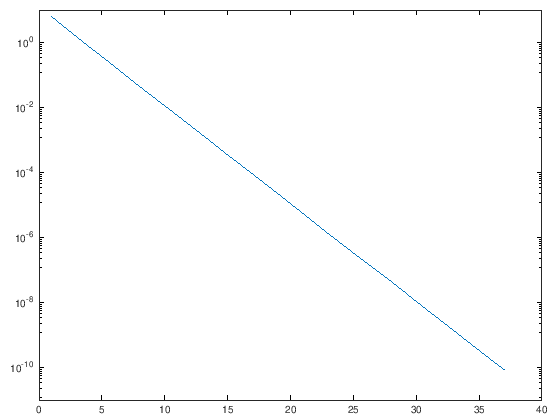

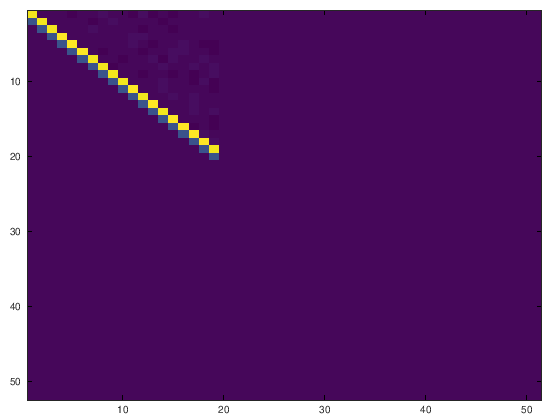

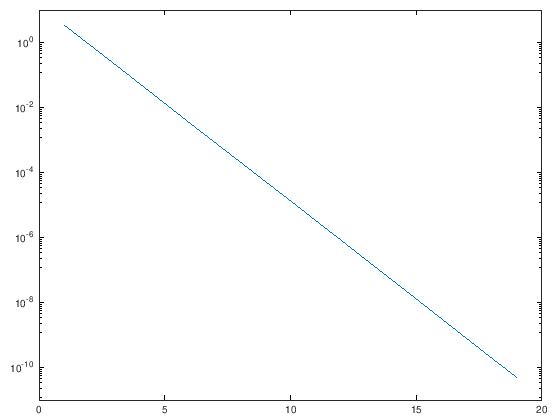

In [18]:
for n = [-4 -2 0 2 4]
    figure();
    printf("🍌 n = %d\n", n)
    [A, b, x0] = generateData2(200, n=n);
    [x, res] = myrgmres(A, b, x0, 50, 1e-10, 100);
    
    % x;
    x_true = A\b;
    approx_error = max(x_true-x)
    normm = norm(A*x - b)
    
    figure();
    title(["GMRES with n = " mat2str(n)]);
    semilogy(res);
end

In [ ]:
%% questo non sembra funzionare
function [B] = myGramschmidt(A)
    B = A;

    for k = 1:size(A, 1)
        for j = 1:k-1
            B(k, :) = B(k, :) - proj(B(j, :), A(k, :));
        end
    end
end

function p = proj(u, v)
% https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process#The_Gram.E2.80.93Schmidt_process
    p = dot(v, u) / dot(u, u) * u;
end

In [ ]:
function [U]=gramschmidt(V)
[n,k] = size(V);
U = zeros(n,k);
U(:,1) = V(:,1)/norm(V(:,1));
for i = 2:k
    U(:,i)=V(:,i);
    for j=1:i-1
        U(:,i)=U(:,i)-(U(:,j)'*U(:,i)) * U(:,j);
    end
    U(:,i) = U(:,i)/norm(U(:,i));
end
end

In [ ]:
aaa = [1 2 3]
aaa = [aaa 90]

In [ ]:
aaa(end)

In [ ]:
aaa = []
aaa = [aaa 2]
aaa = [aaa 22]

In [ ]:
function [Q, H, breakdown] = ANROLDI(A, b,Qold, Hold, n, tol)
    Hold
    if any(Hold) || isempty(Hold)
        H = [0 0]'
    else
%         H = [Hold 0;
%              0 0];
        H = [Hold zeros(size(Hold, 1), 1);
            zeros(1, size(Hold, 2) + 1)];
    end
    
    Q = [Qold  zeros(size(Qold, 1), 1)];
%     Qold
    w = A * Q(:, n);
    
    for i = max(1, n-1):n
        H(i, n) = Q(:, i)' * w;
        w = w - H(i, n) * Q(:, i);
    end
    w
    H(n+1, n) = norm(w);
    breakdown = norm(H(n+1, n)) < tol;
    Q(:, n+1) = w/norm(w);
endfunction

In [ ]:
function [x res] = altrogmres(A, b, x0, k, tol)
    Q = ones(size(b, 1), size(b, 1));
%     Q = zeros(;
    H = [];
    r0 = b - A * x0;
    beta = norm(r0, 2);
    e1 = zeros(size(b, 1), 1);
    e1(1) = 1;
    res = 0;
    for j=1:k
        [Q, H, breakdown] = ANROLDI(A, b, Q, H, j, tol);
        
        if (abs(H(j+1, j)) > tol)
            Q(:, j+1) = Q(:,j+1)/H(j+1,j);
        end
        
        e1 = zeros(j+1, 1);
        e1(1) = 1;

%         y =(H(1:j+2,1:j+1))\(beta *e1);
        y =H\(beta *e1(1:j+1));
%         res = norm(H(1:j+1,1:j)*y - beta*e1, 2);
        x = Q(:, 1:j) * y
%         disp(H(j+1,j))
%         disp(e1(1:j+1)*y)
%         res = (H(j+1,j) * abs(e1*y))/beta;
%         if (res < tol)
%             disp('Raggiunta toll');
%             x = Q(:, 1:j+1)*y +x0;
%             return;
%         end
    end
endfunction


In [ ]:
[x res] = altrogmres(A, b, x0, 10, 1e-10);

In [ ]:
isempty([])
all([1 2 30])
any([0 0 0])
2 < 4
any([])

In [ ]:
x
A\b

In [ ]:
t = [1 1 2;
     2 2 3;
     0 2 1;]

In [ ]:
[t zeros(size(t, 1), 1);
    zeros(1, size(t, 2) + 1)]

In [ ]:
size(t, 2)

In [ ]:
x
real_x = A\b
max(real_x - x)

In [ ]:
imshow(A);

In [ ]:
test = [1 1 1 0 0;
        0 1 1 1 0;
        0 0 1 1 1;
        0 0 0 1 1;]

In [ ]:
imshow(test);

In [ ]:
a = size([1 2 3])(2)

In [ ]:
dim = 20;
A = sprand(dim, dim, .5);
b = rand(dim, 1);
x0 = zeros(dim, 1);

In [ ]:
rand("seed", 20);


In [ ]:
real_res = A\b;

In [ ]:
real_res - x

In [ ]:
max(real_res- x )

In [ ]:
rand(1, 3)

In [ ]:
rand(3, 1)

In [ ]:
rand(3)

In [ ]:
zeros(3, 1)

In [ ]:
function [x res] = cgmres(A, b, x0, k, tol)
    n = size(b)(1);
    Q = zeros(n, k+1);
    H = zeros(k+1, k);
    r0 = b - A * x0;
    beta = norm(r0, 2);
    Q(:, 1) = r0/norm(r0, 2);
%     e1 = zeros(n, 1);
%     e1(1) = 1;
%     e1 = e1';
    for j = 1:k  %% TODO: ricontrollare
        imagesc(H);
        disp(j);
        
        Q(:,j+1) = A * Q(:, j);
        
        for i = 1:j
            H(i,j) = Q(:,i)' * Q(:, j+1);
            Q(:, j+1) = Q(:, j+1) - H(i,j) * Q(:,i);
        end
        
        H(j+1, j) = norm(Q(:, j+1), 2);
        
        if (abs(H(j+1, j)) > tol)
            Q(:, j+1) = Q(:,j+1)/H(j+1,j);
        end
        
        e1 = zeros(j+2, 1);
        e1(1) = 1;
%         e1 = e1';
        %%TODO: ricontrollare
%         y=0
        y =(H(1:j+2,1:j+1))\(beta *e1);
        res = norm(H(1:j+2,1:j+1)*y - beta*e1, 2);
        
        if (res < tol)
            disp('Raggiunta toll');
            x = Q(:, 1:j+1)*y +x0;
            return;
        end
    end
    x = Q(:, 1:j+1)*y +x0;
%     return;   % potrebbe essere superfluo
endfunction